Using kernel `conda_pytorch_latest_p36`

In [1]:
# !pip install fastai

In [2]:
classes = [
    'Agricolture',
    'Cross',
    'Education',
    'Food Security',
    'Health',
    'Livelihoods',
    'Logistics',
    'Nutrition',
    'Protection',
    'Shelter',
    'Wash'
]

In [3]:
import torch

In [4]:
from pathlib import Path
import os
import random
import pickle

In [5]:
from fastai.text.all import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [6]:
data = Path('data_prep/final_data/en/')
raw = pd.read_csv('data_prep/data/entries_raw.csv')

In [7]:
train = pd.read_csv(data / 'sentences_en_train.csv')
test = pd.read_csv(data / 'sentences_en_test.csv')

In [22]:
def process_for_sector(df, sector, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    
    positive_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector in x)]
    negative_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector not in x)]

    positive_train.sector_ids = 1
    negative_train.sector_ids = 0
    train_df = pd.concat([positive_train, negative_train])
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    train_df['is_valid'] = False if train else True
        
    return train_df

In [23]:
def process_multiclass(df, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: ';'.join(classes[i] for i in x))
#     relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: [classes[i] for i in x][0])

    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    
    

# Pretraining with fastai

In [28]:
dls_lm = TextDataLoaders.from_df(
    raw,
    text_col='modified_excerpt_text',
    valid_pct=0.1,
    is_lm = True,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
dls.show_batch(max_n=5)

,text,text_
0,"xxbos [ september 10 - 23 , xxup nes , challenges to mitigate xxup covid 19 ] xxmaj key challenges in relation to xxup covid-19 risk mitigation and response capacity include the poor adherence to lockdown / preventative measures , underreporting of symptoms ( especially when mild ) among the camp population with many people refusing to relocate to the isolation area . xxbos xxmaj pour le président de xxunk - l","[ september 10 - 23 , xxup nes , challenges to mitigate xxup covid 19 ] xxmaj key challenges in relation to xxup covid-19 risk mitigation and response capacity include the poor adherence to lockdown / preventative measures , underreporting of symptoms ( especially when mild ) among the camp population with many people refusing to relocate to the isolation area . xxbos xxmaj pour le président de xxunk - l ,"
1,"were collected from suspected xxmaj covid-19 patients in the last 24 hours . xxmaj as many as 12,650 samples , including some pending ones , were tested at the 167 authorized labs — government and private — across the country . xxmaj the latest figures showed an infection rate of 8.29 % . xxbos [ xxup nes , xxmaj dec ] xxmaj xxunk camp : xxmaj cases : xxmaj no cases reported","collected from suspected xxmaj covid-19 patients in the last 24 hours . xxmaj as many as 12,650 samples , including some pending ones , were tested at the 167 authorized labs — government and private — across the country . xxmaj the latest figures showed an infection rate of 8.29 % . xxbos [ xxup nes , xxmaj dec ] xxmaj xxunk camp : xxmaj cases : xxmaj no cases reported in"
2,"professionals would be largely vaccinated on the first day . xxmaj however , reports showed local representatives and government officials were prioritized instead . xxmaj ministers and high - ranking officials took the first jabs at the centers in the capital while mps , divisional commissioners , or deputy commissioners ( xxunk ) inaugurated their district level programs . xxmaj they got vaccinated in an attempt to encourage people to register for","would be largely vaccinated on the first day . xxmaj however , reports showed local representatives and government officials were prioritized instead . xxmaj ministers and high - ranking officials took the first jabs at the centers in the capital while mps , divisional commissioners , or deputy commissioners ( xxunk ) inaugurated their district level programs . xxmaj they got vaccinated in an attempt to encourage people to register for vaccines"
3,"2019 to 30th xxmaj september 2020 , comprised of xxunk xxunk ) . 83 % of the spontaneous refugee returnees report to have been unregistered with authorities in the country of asylum . xxup unhcr xxmaj nigeria is working closely with partners to implement a comprehensive response strategy , including providing targeted assistance to returning xxmaj nigerians , developing the capacity of key stakeholders to the response and xxunk for conditions of","to 30th xxmaj september 2020 , comprised of xxunk xxunk ) . 83 % of the spontaneous refugee returnees report to have been unregistered with authorities in the country of asylum . xxup unhcr xxmaj nigeria is working closely with partners to implement a comprehensive response strategy , including providing targeted assistance to returning xxmaj nigerians , developing the capacity of key stakeholders to the response and xxunk for conditions of returns"
4,"xxunk them with their families , as well as providing psychological first aid to ensure children feel safe and protected . xxbos [ dec 2020 , xxup nws ] 423 hfs functional compared to 396 in 3rd quarter 2020 . xxmaj the breakdown of the functioning health facilities is as follows \n\n 63 ( 15 % ) are xxmaj hospitals , 173 ( 41 % ) are fixed phcs , 83 (","them with their families , as well as providing psychological first aid to ensure children feel safe and protected . xxbos [ dec 2020 , xxup nws ] 423 hfs functional compared to 396 in 3rd quarter 2020 . xxmaj the breakd

In [15]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [16]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.091970,3.733645,0.333683,41.831326,08:41


In [18]:
pwd

'/home/ec2-user/SageMaker/experiments-dfs'

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.724900,3.533549,0.356897,34.245300,09:57
1,3.470097,3.333563,0.380279,28.038067,09:56
2,3.287098,3.167332,0.398922,23.744043,09:56
3,3.154584,3.066421,0.410630,21.464931,09:56
4,3.016346,2.986583,0.421629,19.817854,09:56
5,2.935730,2.932996,0.429213,18.783827,09:56
6,2.828352,2.899021,0.435023,18.156361,09:56
7,2.764089,2.878101,0.438352,17.780470,09:56
8,2.725973,2.870147,0.440028,17.639606,09:56
9,2.681025,2.869824,0.440240,17.633917,09:56


In [20]:
learn.save_encoder('finetuned')

# Use fastai

In [24]:
train_df = process_multiclass(train, True)
test_df = process_multiclass(test, False)
df = pd.concat([train_df, test_df])

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
dls = TextDataLoaders.from_df(
    df,
    text_col='sentence_text',
    label_col='sector_ids',
    label_delim=';',
    valid_col='is_valid',
    is_lm = False,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
    y_block=MultiCategoryBlock,
    text_vocab=dls_lm.vocab,
)
learn = text_classifier_learner(
    dls, 
    AWD_LSTM, 
    drop_mult=0.5, 
    metrics=[
        accuracy_multi, 
        RecallMulti(thresh=0.35), 
        PrecisionMulti(thresh=0.35), 
        F1ScoreMulti(thresh=0.35), 
        RocAucMulti()
    ]
)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
learn = learn.load_encoder('finetuned')

In [31]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.219619,0.208932,0.921855,0.537709,0.625068,0.574201,0.888888,00:59


In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.204921,0.201038,0.925828,0.558615,0.636169,0.589695,0.896844,01:08


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.188564,0.194136,0.930019,0.624301,0.656154,0.635673,0.902883,01:39


In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.174221,0.191645,0.930958,0.620416,0.672335,0.642543,0.904927,02:11
1,0.166373,0.193153,0.930614,0.631178,0.653438,0.637467,0.904993,02:10


In [35]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.view(-1).numpy() > threshold).astype(int)
        t_targets = targets.view(-1).numpy()
        precisions.append(precision_score(t_preds, t_targets))
        recalls.append(recall_score(t_preds, t_targets))    
        f1_scores.append(f1_score(t_preds, t_targets))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [36]:
def get_best_threshold(learner, num_thresholds=20):
    train_preds, train_targets = learn.get_preds(0)
    train_metrics = get_threshold_metrics(train_preds, train_targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold

In [37]:
def get_metrics(preds, targets):
    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    
    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]
        
        indexes.append(class_)
        precisions.append(precision_score(class_preds, class_targets))
        recalls.append(recall_score(class_preds, class_targets))    
        f1_scores.append(f1_score(class_preds, class_targets))        
        
    indexes.append('all')
    precisions.append(precision_score(preds.view(-1), targets.view(-1)))
    recalls.append(recall_score(preds.view(-1), targets.view(-1)))    
    f1_scores.append(f1_score(preds.view(-1), targets.view(-1)))       

    
    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('class', drop=True)
    
    return all_metrics

In [38]:
def evaluate(learner, threshold):
    test_preds, test_targets = learn.get_preds(1)
    

In [39]:
best_threshold = get_best_threshold(learn)
print(best_threshold)

0.35


In [40]:
test_preds, test_targets = learn.get_preds(1)
test_discrete_preds = (test_preds > best_threshold).int()
test_discrete_targets = test_targets.int()

In [41]:
multi_label_metrics = get_metrics(test_discrete_preds,test_discrete_targets)

In [42]:
multi_label_metrics

,recall,precision,f1_score
class,,,
Agricolture,0.566038,0.652174,0.606061
Cross,0.452471,0.521930,0.484725
Education,0.757576,0.655022,0.702576
Food Security,0.675879,0.684478,0.680152
Health,0.873622,0.817460,0.844608
Livelihoods,0.578035,0.561798,0.569801
Logistics,0.659574,0.446043,0.532189
Nutrition,0.589928,0.713043,0.645669
Protection,0.665060,0.652482,0.658711


<AxesSubplot:xlabel='class'>

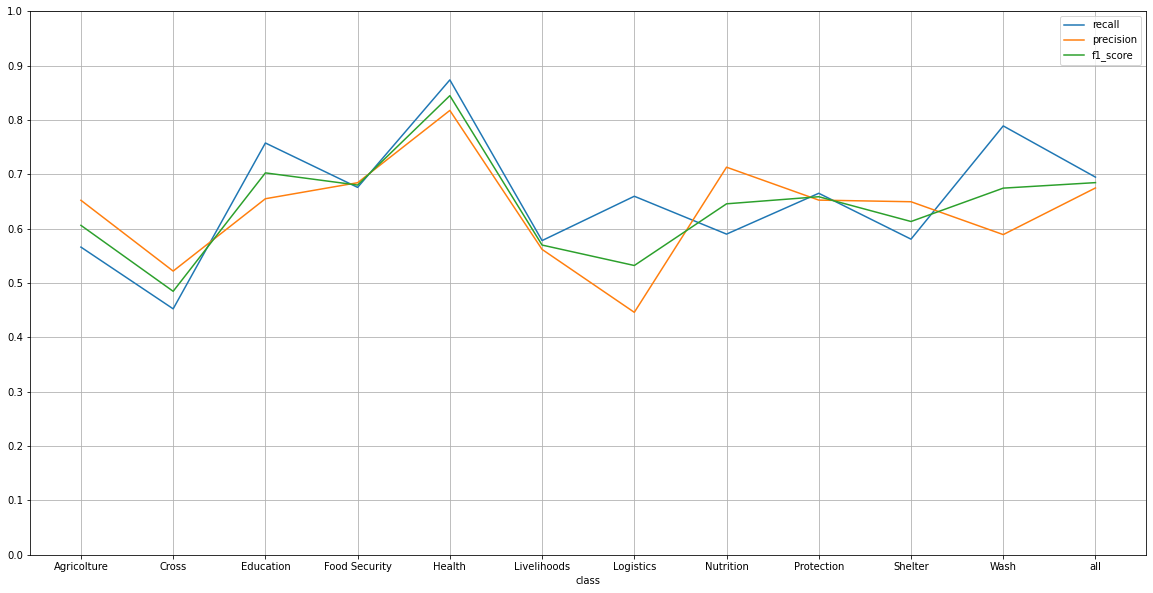

In [43]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

<AxesSubplot:xlabel='class'>

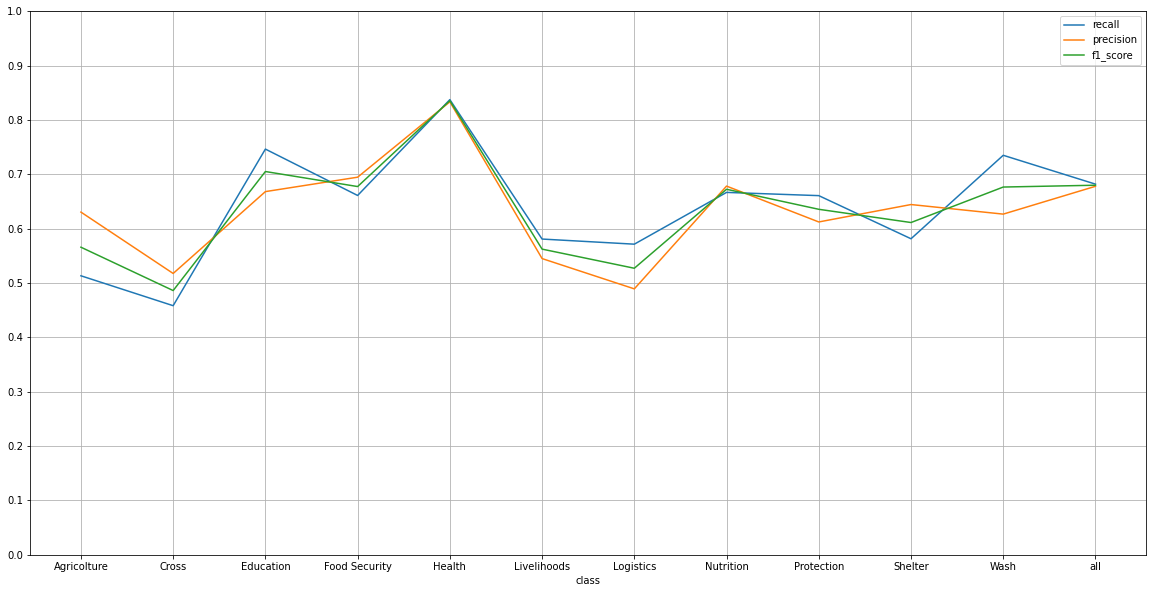

In [49]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

In [45]:
base = Path('/home/ec2-user/SageMaker/experiments-dfs/models/fastai/results')

In [46]:
with open(base / 'pretrained_multi_label.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)